In [ ]:
!pip install shap

In [ ]:
!pip install -U hopsworks --quiet

In [ ]:
    import hopsworks
    import pandas as pd
    # from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    # from sklearn.linear_model import SGDClassifier
    # from sklearn.naive_bayes import BernoulliNB
    from sklearn.pipeline import Pipeline, make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [ ]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/189588
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
# The feature view is the input set of features for your model. The features can come from different feature groups.
# You can select features from different feature groups and join them together to create a feature view
# diabetes_fg = fs.get_feature_group(name="diabetes", version=1)
diabetes_fg = fs.get_feature_group(name="diabetes_gan", version=1)
query = diabetes_fg.select_all()
# feature_view = fs.get_or_create_feature_view(name="diabetes",
feature_view = fs.get_or_create_feature_view(name="diabetes_gan",
                                  version=1,
                                  description="Read from Diabetes dataset",
                                  labels=["diabetes"],
                                  query=query)

In [ ]:
diabetes_df = pd.DataFrame(diabetes_fg.read())
diabetes_df.describe()

Finished: Reading data from Hopsworks, using ArrowFlight (1.12s) 


age            bmi    hba1c_level  blood_glucose_level  \
count  153521.000000  153521.000000  153521.000000        153521.000000   
mean       50.052206      29.326898       5.984060           173.716736   
std        22.141041       7.820200       1.093770            65.101326   
min        -4.041839      10.010000       3.500000            80.000000   
25%        34.000000      25.550000       5.700000           130.000000   
50%        55.000000      27.422807       6.096647           158.000000   
75%        68.279673      31.928251       6.508532           216.000000   
max        82.235070      95.690000       9.241805           313.000000   

            diabetes  
count  153521.000000  
mean        0.495339  
std         0.499980  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [ ]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.05s) 


In [ ]:
# from sklearn.svm import SVC

# pipe = make_pipeline(StandardScaler(), BernoulliNB())
# pipe = make_pipeline(StandardScaler(), SGDClassifier())
rf = RandomForestClassifier(random_state=42)
# pipe = make_pipeline(StandardScaler(), rf)
# pipe = make_pipeline(StandardScaler(), SVC(gamma='auto'))
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = rf.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [ ]:
print(metrics)
# metrics

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15442
           1       0.99      0.97      0.98     15263

    accuracy                           0.98     30705
   macro avg       0.98      0.98      0.98     30705
weighted avg       0.98      0.98      0.98     30705



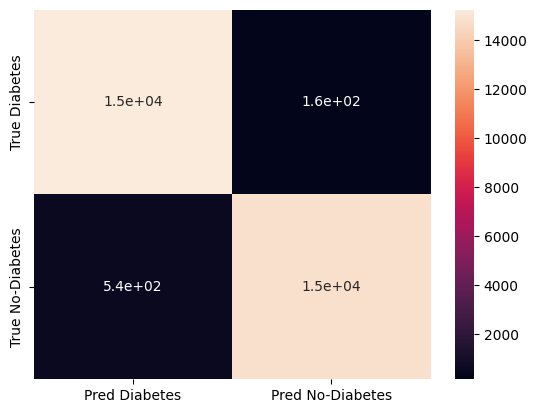

In [ ]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Diabetes', 'True No-Diabetes'],
                     ['Pred Diabetes', 'Pred No-Diabetes'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

# Explainability

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(rf)

In [26]:
samples = shap.sample(X_test, 100)
shap_values = explainer.shap_values(samples, approximate=True)

In [59]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0], samples)

In [58]:
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[0][0,:], samples.iloc[0,:])

# Overall feature impact

In [52]:
print(shap_values[0][0,:])

[-0.07719398  0.06241296 -0.06003638 -0.43055624]


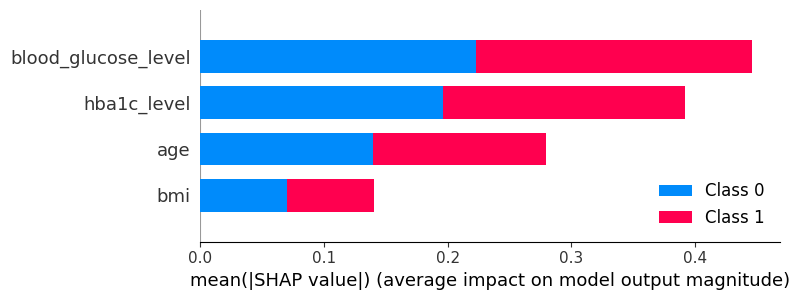

In [ ]:
shap.summary_plot(shap_values, samples)

# Feature impact on Diabetes prediction

E.g. People with smaller blood _glucose_level are less likely to be predicted with Diabetes.

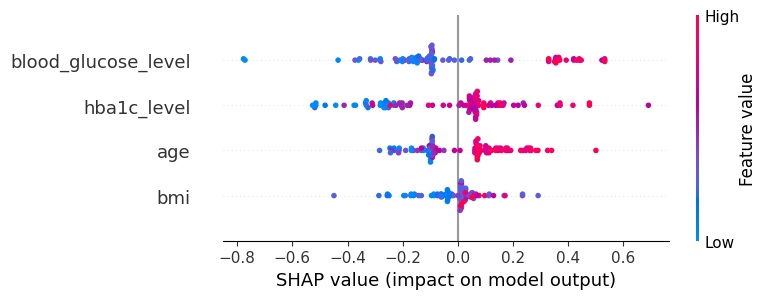

In [ ]:
shap.summary_plot(shap_values[1], samples)

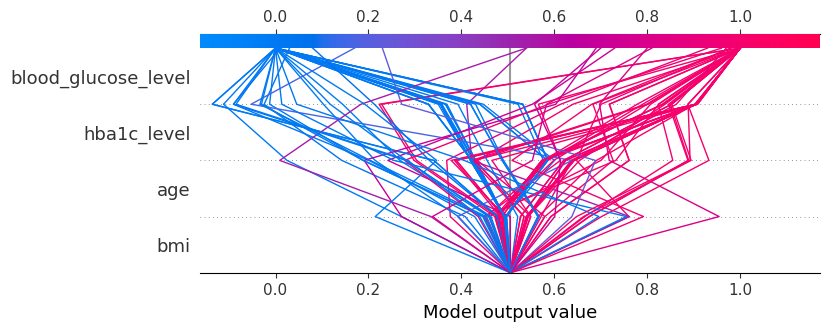

In [37]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], samples.keys())

In [36]:
samples.keys()

Index(['age', 'bmi', 'hba1c_level', 'blood_glucose_level'], dtype='object')

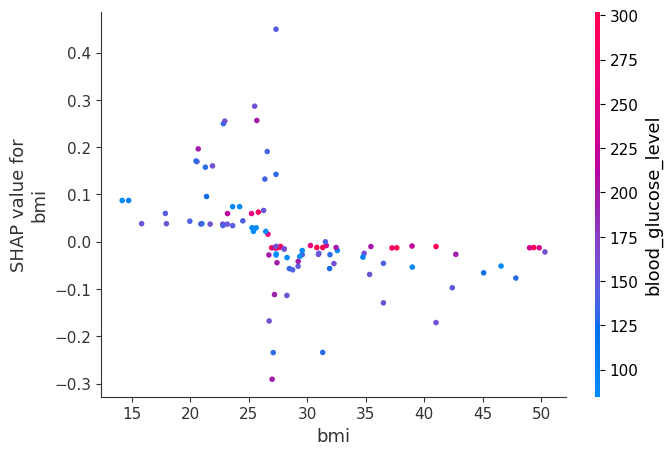

In [28]:
shap.dependence_plot("bmi", shap_values[0], samples)

# Model registry

In [ ]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="diabetes_gan_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(pipe, model_dir + "/diabetes_gan_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")


# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
diabetes_model = mr.python.create_model(
    name="diabetes_gan_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Diabetes Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
diabetes_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/22323 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/50158911 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/468 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/189588/models/diabetes_gan_model/2


Model(name: 'diabetes_gan_model', version: 2)

In [ ]:
print(model_dir)

diabetes_gan_model
